# BERT for naive classification

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from json import loads


tqdm.pandas()

In [2]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

%env HF_HUB_DISABLE_SYMLINKS_WARNING=1

c:\Users\artur\source\prog_ag\proj\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


env: HF_HUB_DISABLE_SYMLINKS_WARNING=1


In [3]:
import torch
print(torch.cuda.is_available())

True


In [23]:
from torch.utils.data import DataLoader, Dataset
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

In [5]:
SEED = 22

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [6]:
df_l_clean = pd.read_csv("labeled_ner_emo.csv")
df_l_clean["named_entities"] = df_l_clean["named_entities_json"].apply(
    loads
)
df_l_clean["emotion"] = df_l_clean["emotion_json"].apply(
    loads
)
df_l_clean

,replyDate,reply,telegramChannel,Label,named_entities,named_entities_json,emotion,emotion_json
0,1687098753,And HANG SCHIFF AND NADLER PELOSI AND ALL THE...,TrumpSupportersChannel.json,2,"[{'entity_group': 'PER', 'score': 0.5087380409...","[{""entity_group"": ""PER"", ""score"": 0.5087380409...","[{'label': 'neutral', 'score': 0.6424934267997...","[{""label"": ""neutral"", ""score"": 0.6424934267997..."
1,1698117741,Can we please get to the EXECUTIONS ALREADY 🖕🏽💀💩,ResisttheMainstream.json,2,"[{'entity_group': 'MISC', 'score': 0.748939037...","[{""entity_group"": ""MISC"", ""score"": 0.748939037...","[{'label': 'neutral', 'score': 0.6776106953620...","[{""label"": ""neutral"", ""score"": 0.6776106953620..."
2,1684179732,Can't trust Musk as far u can shoot that fucki...,ResisttheMainstream.json,2,"[{'entity_group': 'PER', 'score': 0.8127702474...","[{""entity_group"": ""PER"", ""score"": 0.8127702474...","[{'label': 'anger', 'score': 0.945322871208190...","[{""label"": ""anger"", ""score"": 0.945322871208190..."
3,1623339801,There are so many criminals in America dishone...,TheTrumpRepublicans.json,2,"[{'entity_group': 'LOC', 'score': 0.9989275336...","[{""entity_group"": ""LOC"", ""score"": 0.9989275336...","[{'label': 'neutral', 'score': 0.7125468254089...","[{""label"": ""neutral"", ""score"": 0.7125468254089..."
4,1685904529,"Traitors all, hang ‘em high",ResisttheMainstream.json,2,"[{'entity_group': 'LOC', 'score': 0.4548235535...","[{""entity_group"": ""LOC"", ""score"": 0.4548235535...","[{'label': 'neutral', 'score': 0.8668019175529...","[{""label"": ""neutral"", ""score"": 0.8668019175529..."
...,...,...,...,...,...,...,...,...
15055,1630362047,Hmmm. I’m not believing this anymore. Wtf. ARR...,AnalyzingAmerica.json,1,"[{'entity_group': 'MISC', 'score': 0.462011128...","[{""entity_group"": ""MISC"", ""score"": 0.462011128...","[{'label': 'anger', 'score': 0.526343822479248...","[{""label"": ""anger"", ""score"": 0.526343822479248..."
15056,1678747240,Indian gonna scalp her,ResisttheMainstream.json,2,"[{'entity_group': 'MISC', 'score': 0.775369107...","[{""entity_group"": ""MISC"", ""score"": 0.775369107...","[{'label': 'anger', 'score': 0.703433156013488...","[{""label"": ""anger"", ""score"": 0.703433156013488..."
15057,1696303318,Why didn’t capital police arrest him! They wou...,ResisttheMainstream.json,1,[],[],"[{'label': 'anger', 'score': 0.794587194919586...","[{""label"": ""anger"", ""score"": 0.794587194919586..."
15058,1662850264,Pup play but they're seal pups and I club them,RiotDogs.json,0,[],[],"[{'label': 'neutral', 'score': 0.8287609219551...","[{""label"": ""neutral"", ""score"": 0.8287609219551..."


In [7]:
df_l_clean["Label"] = df_l_clean["Label"].astype("uint8")

In [8]:
BATCH_SIZE = 64
NUM_EPOCHS = 10
NON_IMPROVING_LOSS_TEMPERANCE = 3

In [9]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
for param in model.base_model.parameters():
    param.requires_grad = False
    
for layer in model.base_model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

In [11]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [12]:
df_l_split = df_l_clean.sample(frac=1).reset_index(drop=True)

train_size = int(0.8 * len(df_l_split))
train_df = df_l_split.iloc[:train_size]
test_df = df_l_split.iloc[train_size:]

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [13]:
train_df

,replyDate,reply,telegramChannel,Label,named_entities,named_entities_json,emotion,emotion_json
0,1669114113,All of them better b under the jail. It's beli...,ResisttheMainstream.json,1,[],[],"[{'label': 'sadness', 'score': 0.3737834393978...","[{""label"": ""sadness"", ""score"": 0.3737834393978..."
1,1694906630,Not feeling so sorry for inner city shits thes...,ThePatriotVoice.json,0,[],[],"[{'label': 'sadness', 'score': 0.9200736880302...","[{""label"": ""sadness"", ""score"": 0.9200736880302..."
2,1648263568,AOC and Biden are puppets for the NWO.,AnalyzingAmerica.json,0,"[{'entity_group': 'PER', 'score': 0.7841899394...","[{""entity_group"": ""PER"", ""score"": 0.7841899394...","[{'label': 'neutral', 'score': 0.8979731202125...","[{""label"": ""neutral"", ""score"": 0.8979731202125..."
3,1618888805,Jail for inciting violence and insurrection! S...,AnalyzingAmerica.json,1,"[{'entity_group': 'PER', 'score': 0.3539868593...","[{""entity_group"": ""PER"", ""score"": 0.3539868593...","[{'label': 'anger', 'score': 0.81219482421875}...","[{""label"": ""anger"", ""score"": 0.81219482421875}..."
4,1651932624,Beat the shit out of them and throw them out!!!,TrumpSupportersChannel.json,2,[],[],"[{'label': 'anger', 'score': 0.946243643760681...","[{""label"": ""anger"", ""score"": 0.946243643760681..."
...,...,...,...,...,...,...,...,...
12043,1633289556,I hope the timers are true the internet will s...,AnalyzingAmerica.json,2,"[{'entity_group': 'ORG', 'score': 0.5075713396...","[{""entity_group"": ""ORG"", ""score"": 0.5075713396...","[{'label': 'neutral', 'score': 0.6471136212348...","[{""label"": ""neutral"", ""score"": 0.6471136212348..."
12044,1619024416,Good keep them the lawsuits coming.,AnalyzingAmerica.json,1,"[{'entity_group': 'MISC', 'score': 0.493371099...","[{""entity_group"": ""MISC"", ""score"": 0.493371099...","[{'label': 'neutral', 'score': 0.8016161918640...","[{""label"": ""neutral"", ""score"": 0.8016161918640..."
12045,1623465886,Thought he was at gitmo,AnalyzingAmerica.json,2,"[{'entity_group': 'ORG', 'score': 0.5160778164...","[{""entity_group"": ""ORG"", ""score"": 0.5160778164...","[{'label': 'neutral', 'score': 0.4931610226631...","[{""label"": ""neutral"", ""score"": 0.4931610226631..."
12046,1622158880,Of course they are going to deny deny deny.......,AnalyzingAmerica.json,0,[],[],"[{'label': 'disgust', 'score': 0.5307360291481...","[{""label"": ""disgust"", ""score"": 0.5307360291481..."


In [14]:
train_dataset = TextDataset(train_df["reply"], train_df["Label"], tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [15]:
test_dataset = TextDataset(test_df["reply"], test_df["Label"], tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [25]:
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
from torchmetrics import Accuracy

accuracy_metric = Accuracy(task="multiclass", num_classes=3).to(device)

In [26]:
best_test_loss = 0
non_improving_loss_epochs = 0


for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss:.4f}")

    scheduler.step()
    
    model.eval()
    test_loss = 0
    test_preds, test_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            test_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            test_preds.extend(preds.cpu())
            test_labels.extend(labels.cpu())

    test_preds = torch.stack(test_preds, dim=0)
    test_labels = torch.stack(test_labels, dim=0)

    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = accuracy_metric(test_preds, test_labels)
    print(f"Test Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

    if epoch == 0:
        best_test_loss = avg_test_loss

    if avg_test_loss <= best_test_loss:
        best_test_loss = avg_test_loss
        non_improving_loss_epochs = 1
    else:
        non_improving_loss_epochs += 1

    if non_improving_loss_epochs > NON_IMPROVING_LOSS_TEMPERANCE:
        print(f"Finished early. Best loss: {best_test_loss:.4f}")
        break

Epoch 1/10, Train Loss: 0.1527
Test Loss: 0.5017, Accuracy: 0.8546
Epoch 2/10, Train Loss: 0.1323
Test Loss: 0.4896, Accuracy: 0.8529
Epoch 3/10, Train Loss: 0.1018
Test Loss: 0.4965, Accuracy: 0.8602
Epoch 4/10, Train Loss: 0.0906
Test Loss: 0.5099, Accuracy: 0.8619
Epoch 5/10, Train Loss: 0.0889
Test Loss: 0.5113, Accuracy: 0.8612
Finished early. Best loss: 0.4896


In [27]:
torch.save(model, "naive_bert_classifier_full.pth")

In [31]:
from sklearn.metrics import confusion_matrix

In [29]:
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu())
        test_labels.extend(labels.cpu())

test_preds = torch.stack(test_preds, dim=0)
test_labels = torch.stack(test_labels, dim=0)

In [38]:
cm = confusion_matrix(test_labels, test_preds)
cm

array([[796, 109, 139],
       [ 44, 870,  24],
       [ 79,  23, 928]])

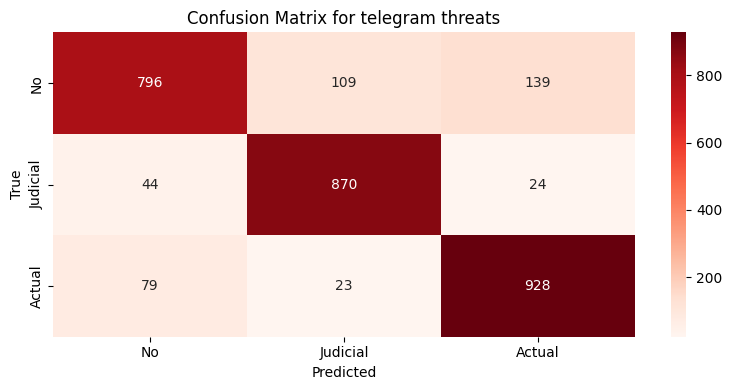

In [49]:
plt.figure(figsize=(8, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['No', 'Judicial', 'Actual'],
            yticklabels=['No', 'Judicial', 'Actual']
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for telegram threats')
plt.tight_layout()
plt.show()